# Problem 5.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
import sys
from functools import partial 
from scipy import stats, optimize
import scipy
from tqdm import tqdm

# The file www.nbi.dk/petersen/data GlacierSizes.csv contains the estimated area and
volume including uncertainties of 434 glaciers with an area above 1 km2

- Plot volume as a function of area. Which of the two have largest relative uncertainties?
The volume as a function of area is shown in figure

The relative uncertainty of a measurement is given by the magnitude of the uncertainty divided by the magnitude of the measurement

$$\frac{\sigma_{x}}{x}$$

This was calculated for all measurements of area and volume. The arithmetic means was used to estimate the average relative uncertainty for both variables.
This gives an average relative uncertainty of Area, $\mu_A$ = 0.013, and an average relative uncertainty of Volume, $\mu_V$ = 0.10.
It is thus volume which has the largest relative uncertainty.



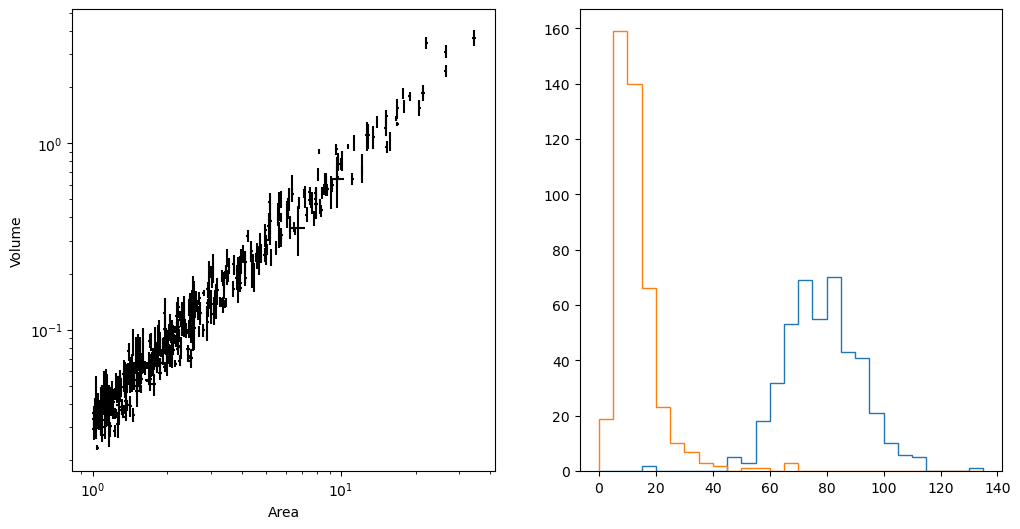

In [2]:
data = np.genfromtxt('data_GlacierSizes.csv', delimiter = ',', skip_header = 1)

Area_uncertain = data[:,0] / data[:,1]
Volume_uncertain = data[:,2] / data[:,3]

area = data[:,0]
area_err = data[:,1]
volume = data[:,2]
volume_err = data[:,3]

fig, ax = plt.subplots(1,2, figsize = (12, 6))
ax[0].errorbar(data[:,0], data[:,2], xerr = data[:,1], yerr = data[:,3], ls = '', color = 'black')
ax[0].set_xlabel('Area')
ax[0].set_ylabel('Volume')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

bins = np.arange(0,140,5)
ax[1].hist(Area_uncertain, bins = bins, histtype = 'step');
ax[1].hist(Volume_uncertain, bins = bins, histtype = 'step');

- Fit data with the expected Area-Volume relation $V A^{3/2}$ . Assume no area uncertainties.

As we have errors on the volume we use $\chi^2$ to fit the data to the simple function suggested. 
The fitted function returns a very low $\chi^2$ = 387 for the 433 degrees of freedom, resulting in the very high p = 0.946. The fitting function however seems to poorly describe the points at high area, which predominantly lie below the expected values from the fitting function. The density of points at low areas is however very large, likely resulting in in the very high p-value. It could also be that their errors were overestimated, since they can compensate so significantly for an obviously non-flawless fit.
  

In [6]:
def simple_fit(Area,c):
    return c*Area**(3/2)
chi2_fit = cost.LeastSquares( area, volume, volume_err, simple_fit)
minuit_chi2 = Minuit(chi2_fit, 1.0)
minuit_chi2.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4265 (χ²/ndof = 9.9)       │              Nfcn = 15               │
│ EDM = 9.22e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ c    │ 25.22e-3  │  0.08e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        c │
├───┼──────────┤
│ c │ 6.48e-09 │
└───┴──────────┘

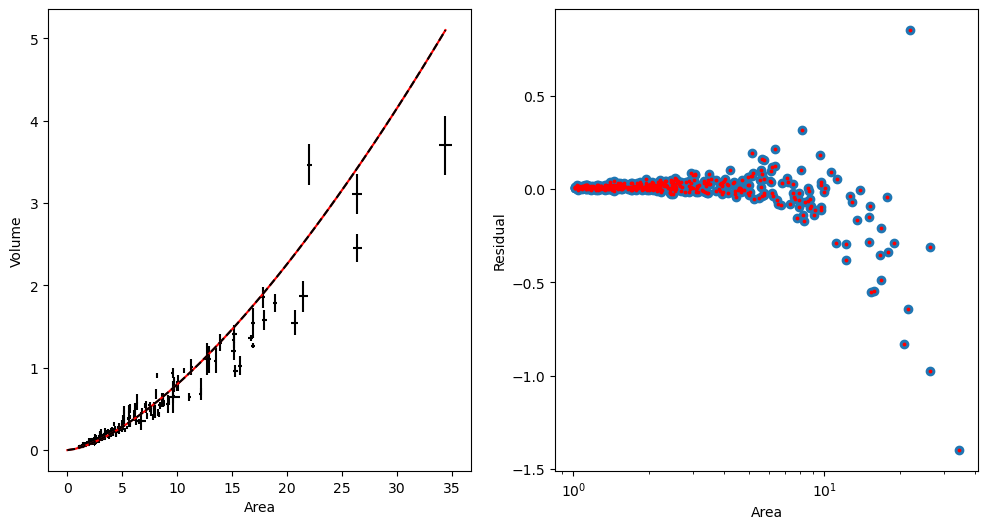

In [7]:
fig, ax = plt.subplots(1,2, figsize = (12,6));

area_array = np.linspace(0, np.max(area))
ax[0].errorbar(data[:,0], data[:,2], xerr = data[:,1], yerr = data[:,3], ls = '', color = 'black');
ax[0].set_xlabel('Area');
ax[0].set_ylabel('Volume');
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
ax[0].plot(area_array, simple_fit(area_array, minuit_chi2.values['c']), color = 'red');

residuals = volume - simple_fit(area, minuit_chi2.values['c']);

ax[1].scatter(area, residuals);
ax[1].set(xlabel = 'Area', ylabel = 'Residual', xscale = 'log');

scipy_chi2, scipy_err = optimize.curve_fit(simple_fit, area, volume, [1], volume_err)
scipy_err = np.sqrt(np.diag(scipy_err))
ax[0].plot(area_array, simple_fit(area_array, scipy_chi2[0]), color = 'black', ls = '--')
residuals = volume - simple_fit(area, scipy_chi2[0]);

ax[1].scatter(area, residuals, color = 'red', s = 3);


In [8]:
sort_residuals  = residuals[np.argsort(area)]
sort_residuals = np.where(sort_residuals > 0, 1, -1)
SR_diff = np.diff(sort_residuals)
n_pos = np.sum(np.where(SR_diff == -2, 1, 0))
n_neg = np.sum(np.where(SR_diff == 2, 1, 0))
n_tot = n_pos + n_neg

R_exp = 2*n_pos*n_neg / (n_neg + n_pos) + 1
R_sig = np.sqrt(2*n_pos*n_neg*(2*n_pos*n_neg-n_pos-n_neg)/((n_pos + n_neg)**2*(n_pos+n_neg -1)))

Z = ( n_tot - R_exp )/ R_sig
print(Z)



11.403717719796328


In [11]:
def advanced_fit(Area,c, exp):
    return c*Area**(exp)
chi2_fit = cost.LeastSquares(area, volume, volume_err, advanced_fit)
minuit_chi2 = Minuit(chi2_fit, 0.01, 3/2)
minuit_chi2.errordef = 1
minuit_chi2.migrad();


- Are you satisfied with the fit? And if not, point out its specific deficiencies

 While the fit returns a $\chi^2$ value which suggests it is good, for the points in regions where point density is low enough that points can be separated visually, the fit seems to overestimate the volumes. This is espicially seen on the logarithmic residual plot above

- Fit again with improved functional form(s), and quantify the improvements.

The basal function before was a good estimate, so it would be wise to further improve the form. To give the fundtion more degrees of freedom to fit, we now also fit the exponent so our fit function becomes
$$f(x) = ax^{b}$$
Using this function we try to fit the data again using a $\chi^2$ approach

The $\chi^2$ value decreased by over 100, which is 10σ and thus very significant considering only one more parameter was included, and especially considering it is unlikely to significantly change the $\chi^2$ value for most of the low area measurements, indicating the description of large glaciers being significantly improved. The $chi^2$ value has however improved by an unrealistic amount, considering the new p = 1.000 suggesting the errors have been overestimated. One could also fit against additional functions, though there is no need, as it is unlikely to find a function capable of achieving a lower $\chi^2$ value (being better at describing the data), and it is not logical to include more fitting parameters in the existing function as the fit is already ’too good’

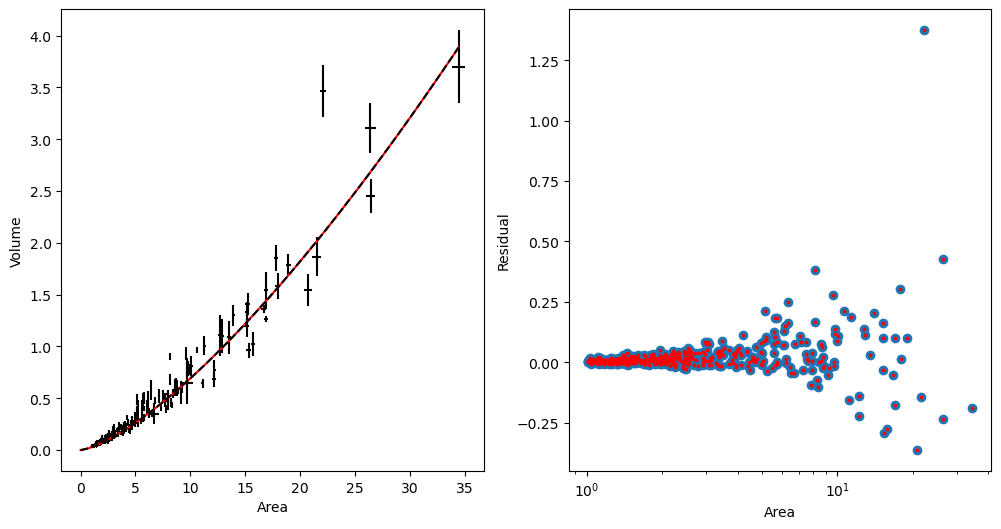

In [12]:
fig, ax = plt.subplots(1,2, figsize = (12,6));

area_array = np.linspace(0, np.max(area))
ax[0].errorbar(data[:,0], data[:,2], xerr = data[:,1], yerr = data[:,3], ls = '', color = 'black');
ax[0].set_xlabel('Area');
ax[0].set_ylabel('Volume');
ax[0].plot(area_array, advanced_fit(area_array, *minuit_chi2.values[:]), color = 'red');

residuals = volume - advanced_fit(area, *minuit_chi2.values[:]);

ax[1].scatter(area, residuals);
ax[1].set(xlabel = 'Area', ylabel = 'Residual', xscale = 'log');

scipy_chi2, scipy_err = optimize.curve_fit(advanced_fit, area, volume, [.1, 3/2], volume_err)
scipy_err = np.sqrt(np.diag(scipy_err))
ax[0].plot(area_array, advanced_fit(area_array, *scipy_chi2[:]), color = 'black', ls = '--')
residuals = volume - advanced_fit(area, *scipy_chi2[:]);

ax[1].scatter(area, residuals, color = 'red', s = 3);

- Redo this fit including the uncertainties in area. How large is the effect of including these?
To include the errors in both x and y we orthogonal
distance regression for each datapoint. This means that the uncertainty on V for the i'th datapoint is:
\begin{align}
\sigma_{V,i} = \sqrt{\sigma_{V0,i}^2 + (c_1\alpha A^{\alpha-1}\sigma_{A,i})^2}
\end{align}
Now fitting with these uncertainties (dependent on the parameters) we obtain the fit as shown in the figure below and the parameter $\alpha$ has slightly increased uncertainty. We obtain the parameters:
$\chi^2 = 2446$ for $Ndf = 433$ and $c_1 = 0.0293 \pm 0.0002$ and $\alpha = 1.394 \pm 0.005 $
  

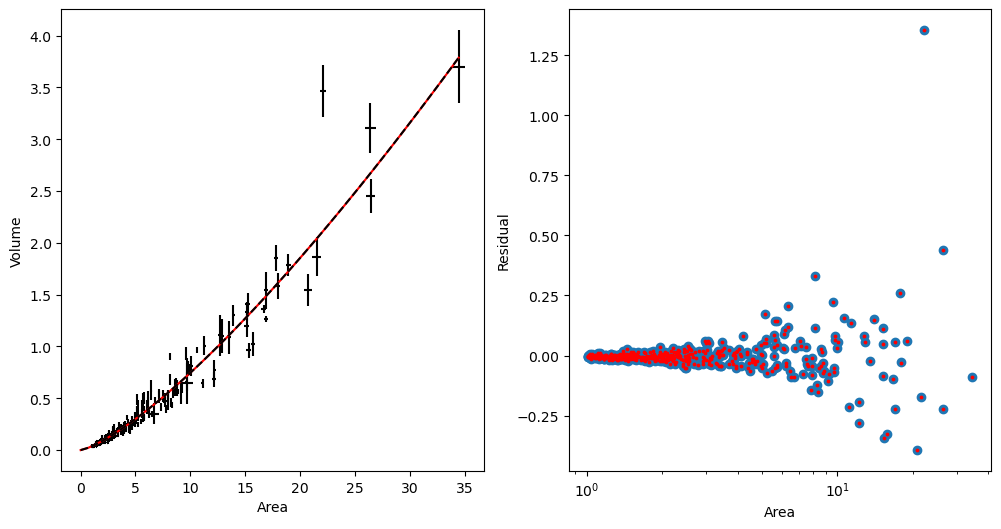

In [14]:
volume_err_area = np.sqrt(volume_err**2 + (area_err/advanced_fit(area, *minuit_chi2.values[:]))**2)

chi2_fit = cost.LeastSquares( area, volume, volume_err_area, advanced_fit)
minuit_chi2 = Minuit(chi2_fit, 0.01, 3/2)
minuit_chi2.errordef = 1
minuit_chi2.migrad()

fig, ax = plt.subplots(1,2, figsize = (12,6));

area_array = np.linspace(0, np.max(area))
ax[0].errorbar(data[:,0], data[:,2], xerr = data[:,1], yerr = volume_err, ls = '', color = 'black');
ax[0].set_xlabel('Area');
ax[0].set_ylabel('Volume');
ax[0].plot(area_array, advanced_fit(area_array, *minuit_chi2.values[:]), color = 'red');

residuals = volume - advanced_fit(area, *minuit_chi2.values[:]);

ax[1].scatter(area, residuals);
ax[1].set(xlabel = 'Area', ylabel = 'Residual', xscale = 'log');

scipy_chi2, scipy_err = optimize.curve_fit(advanced_fit, area, volume, [.01, 3/2], volume_err_area)#same as minuit, we just use another minimizer, but we still get the hesse out that gives us the errors on the fit
scipy_err = np.sqrt(np.diag(scipy_err))
ax[0].plot(area_array, advanced_fit(area_array, *scipy_chi2[:]), color = 'black', ls = '--')
residuals = volume - advanced_fit(area, *scipy_chi2[:]);

ax[1].scatter(area, residuals, color = 'red', s = 3);

-  What volume and with what uncertainty would you expect a glacier of area 0.5 km2 to have?
Here we apply error propagation. We find that 

$$\sigma_{V}(A) = \sqrt{(A^{\alpha}\sigma_{c_1})^2 + (c_1\alpha A^{\alpha-1}\sigma_\alpha)^2} $$

This means that the expected value is

$$V = c_1 0.5^{\alpha} = 0.01116 $$
$$\sigma_{V}(A) = 0.00013 $$

So the estimated volume is: $ V(0.5) = 0.01116 \pm 0.00013$